# Implement dfreq predictor

Calculate delta frequency per clade and assign the resulting values back to each tip.

In [40]:
from augur.frequency_estimators import TreeKdeFrequencies
import Bio.Phylo
from collections import defaultdict
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

%matplotlib inline

plt.style.use("huddlej")

In [2]:
pwd

'/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses'

In [43]:
timepoint_path = "../results/builds/h3n2/5_viruses_per_month/sample_0/2005-10-01--2015-10-01/timepoints/2009-10-01/segments/ha/"
delta_pivots = 1

## Load data

We need to load the tree, frequencies, and clade assignments for a given timepoint.

In [12]:
# Load tree.
tree = Bio.Phylo.read(timepoint_path + "tree.nwk", "newick")

In [13]:
tree

Tree(rooted=False, weight=1.0)

In [5]:
# Load frequencies.
with open(timepoint_path + "frequencies.json", "r") as fh:
    frequencies_json = json.load(fh)
    
frequencies = TreeKdeFrequencies.from_json(frequencies_json)

In [6]:
frequencies.pivots

array([2005.75, 2006.25, 2006.75, 2007.25, 2007.75, 2008.25, 2008.75,
       2009.25, 2009.75])

In [10]:
frequencies.include_internal_nodes

True

In [26]:
# Load clades.
with open(timepoint_path + "clades.json", "r") as fh:
    clades_json = json.load(fh)
    
clades_by_tip = {key: value["clade_membership"] for key, value in clades_json["nodes"].items()}

In [27]:
list(clades_by_tip.keys())[:5]

['A/Afghanistan/AF1169/2008',
 'A/Afghanistan/AF1170/2008',
 'A/Afghanistan/AF1173/2008',
 'A/Aichi/114/2008',
 'A/Aichi/222/2009']

In [86]:
list(clades_by_tip.keys())[-5:]

['NODE_0000799',
 'NODE_0000800',
 'NODE_0000801',
 'NODE_0000802',
 'NODE_0000803']

In [28]:
list(clades_by_tip.values())[:5]

['5ea83cf', 'eacdfa7', '5ea83cf', '1d941a7', 'ca7ba25']

## Identify clade frequencies at current and previous timepoint

Find all tips with non-zero frequencies at the current and previous timepoint. Calculate the total frequency per clade at each timepoint using these tip frequencies.

In [37]:
distinct_clades = sorted(set(clades_by_tip.values()))

In [38]:
len(distinct_clades)

125

In [39]:
distinct_clades[:5]

['067f71e', '0818a58', '08e71a7', '0afa136', '0ba5f43']

In [44]:
current_clade_frequencies = defaultdict(float)
previous_clade_frequencies = defaultdict(float)

for tip in tree.find_clades(terminal=True):
    # Add tip to current clade frequencies if it is currently alive.
    if frequencies.frequencies[tip.name][-1] > 0.0:
        current_clade_frequencies[clades_by_tip[tip.name]] += frequencies.frequencies[tip.name][-1]
    
    # Add tip to previous clade frequencies if it was alive in the last timepoint.
    if frequencies.frequencies[tip.name][-(delta_pivots + 1)] > 0.0:
        previous_clade_frequencies[clades_by_tip[tip.name]] += frequencies.frequencies[tip.name][-(delta_pivots + 1)]

In [45]:
current_clade_frequencies

defaultdict(float,
            {'a68c89f': 0.016998000000000003,
             '8c9c2a3': 1.3e-05,
             '816a19e': 2e-06,
             '3981529': 0.001647,
             '10b53cd': 4e-06,
             'ab0001b': 0.042915,
             'a1211fc': 0.057641,
             '5ea83cf': 0.11183100000000003,
             '9213179': 0.034658999999999995,
             '8c6e6c2': 1e-06,
             'cbb5fb5': 0.012445999999999999,
             'a54d1ad': 0.00034700000000000003,
             'b70fa09': 0.003003,
             'befedfa': 0.034382,
             '68a154d': 0.004334,
             '4692cef': 0.007759,
             'c86656c': 0.056542,
             '6907cdf': 0.021494,
             'dc843fa': 0.010304,
             '5a43b5f': 0.000622,
             'ca15bc8': 0.016583,
             '76d3967': 0.008109,
             'bbf33d0': 0.22100900000000004,
             'ca7ba25': 0.039305,
             '77e0838': 0.012014,
             'fd5868f': 0.010043999999999999,
             '1c3e334':

In [46]:
previous_clade_frequencies

defaultdict(float,
            {'0ecbd50': 0.08893899999999999,
             '08e71a7': 0.000108,
             'a68c89f': 0.093755,
             '63121e8': 0.011248,
             'dbe8977': 1.4e-05,
             '8c9c2a3': 0.005896,
             'b2735ac': 0.029451,
             '816a19e': 0.00072,
             'd5353fb': 2e-06,
             '5c41b66': 0.00266,
             '3981529': 0.009828,
             'eacdfa7': 3.7000000000000005e-05,
             '10b53cd': 0.032354,
             'ab0001b': 0.0013419999999999999,
             'a1211fc': 4.4e-05,
             '5ea83cf': 0.2962340000000001,
             '1d941a7': 0.034183,
             '9213179': 0.06903700000000002,
             '1c3e334': 0.005736,
             '8c6e6c2': 0.008532999999999999,
             'cbb5fb5': 0.0017989999999999998,
             'a54d1ad': 0.026779999999999998,
             'b70fa09': 0.004744,
             'befedfa': 0.038659,
             '68a154d': 0.000974,
             'c86656c': 0.0036239999999999

## Calculate delta frequency per clade

In [49]:
delta_time = frequencies.pivots[-1] - frequencies.pivots[-(delta_pivots + 1)]

In [50]:
delta_time

0.5

In [51]:
delta_frequency_by_clade = {}
for clade, current_frequency in current_clade_frequencies.items():
    delta_frequency_by_clade[clade] = (current_frequency - previous_clade_frequencies.get(clade, 0.0)) / delta_time

Text(0,0.5,'number of clades')

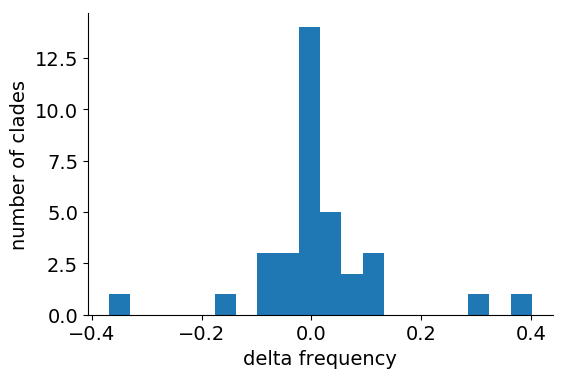

In [55]:
plt.hist(delta_frequency_by_clade.values(), bins=20)
plt.xlabel("delta frequency")
plt.ylabel("number of clades")

In [59]:
np.array(list(delta_frequency_by_clade.values()))

array([-1.53514e-01, -1.17660e-02, -1.43600e-03, -1.63620e-02,
       -6.47000e-02,  8.31460e-02,  1.15194e-01, -3.68806e-01,
       -6.87560e-02, -1.70640e-02,  2.12940e-02, -5.28660e-02,
       -3.48200e-03, -8.55400e-03,  6.72000e-03,  1.55180e-02,
        1.05836e-01,  4.08420e-02,  2.05980e-02,  1.20000e-05,
        3.06300e-02,  1.62180e-02,  4.01488e-01,  7.85740e-02,
       -5.59060e-02, -8.62180e-02, -1.13280e-02, -2.89300e-02,
        2.52660e-02, -5.07000e-03,  3.04524e-01,  1.22788e-01,
        9.38000e-04,  1.69600e-03])

Text(0,0.5,'number of clades')

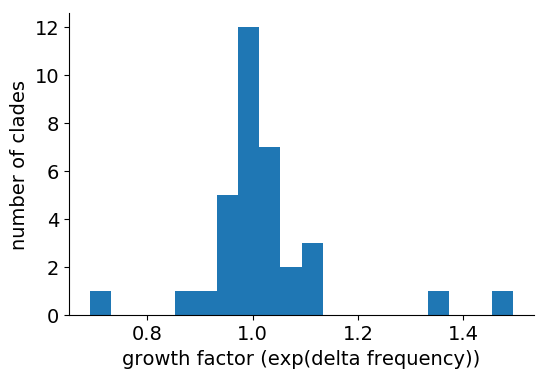

In [71]:
plt.hist(np.exp(np.array(list(delta_frequency_by_clade.values()))), bins=20)
plt.xlabel("growth factor (exp(delta frequency))")
plt.ylabel("number of clades")

If the delta frequency for a clade is 0, then its exponential growth factor based on that fitness estimate will be 1 meaning that there will be no predicted change in frequency if there is no historical change in frequency.

## Propagate clade delta frequencies back to tips

In [73]:
all_deltas = []
extant_deltas = []
delta_frequency = {}
for tip in tree.find_clades(terminal=True):
    delta_frequency[tip.name] = {
        "delta_frequency": delta_frequency_by_clade.get(clades_by_tip[tip.name], 0.0)
    }
    
    all_deltas.append(delta_frequency_by_clade.get(clades_by_tip[tip.name], 0.0))
    
    if frequencies.frequencies[tip.name][-1] > 0.0:
        extant_deltas.append(delta_frequency_by_clade.get(clades_by_tip[tip.name], 0.0))

In [79]:
all_deltas = np.array(all_deltas)
extant_deltas = np.array(extant_deltas)

In [80]:
list(delta_frequency.items())[:5]

[('A/Indonesia/1142/2006', {'delta_frequency': 0.0}),
 ('A/Leiden/87509/2005', {'delta_frequency': 0.0}),
 ('A/Incheon/677/2006', {'delta_frequency': 0.0}),
 ('A/Hanoi/TN403/2005', {'delta_frequency': 0.0}),
 ('A/Seoul/865/2006', {'delta_frequency': 0.0})]

Text(0,0.5,'number of tips')

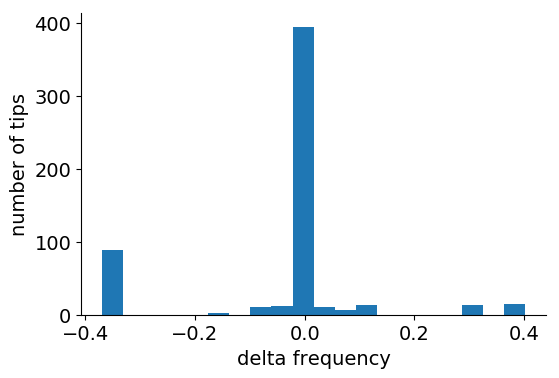

In [81]:
plt.hist(all_deltas, bins=20)
plt.xlabel("delta frequency")
plt.ylabel("number of tips")

Text(0,0.5,'number of tips')

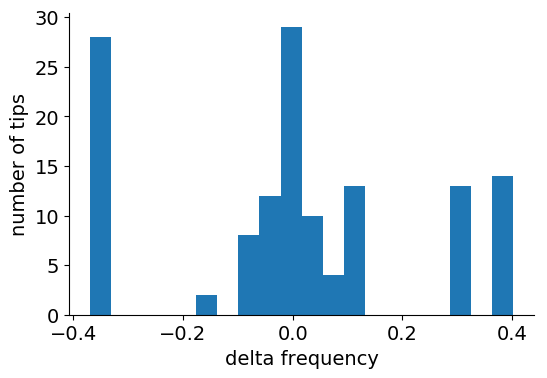

In [82]:
plt.hist(extant_deltas, bins=20)
plt.xlabel("delta frequency")
plt.ylabel("number of tips")

In [83]:
standard_deltas = (extant_deltas - extant_deltas.mean()) / extant_deltas.std()

Text(0,0.5,'number of tips')

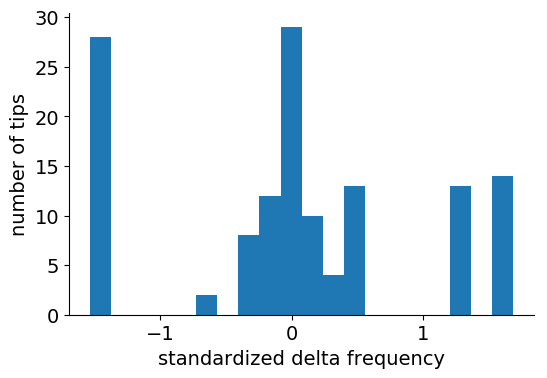

In [84]:
plt.hist(standard_deltas, bins=20)
plt.xlabel("standardized delta frequency")
plt.ylabel("number of tips")

In [85]:
extant_deltas.std()

0.23896209891050693